# Classifying handwritten digits from the MNIST dataset

## Fetching MNIST data

In [42]:
import os
import random
from six.moves import urllib
random.seed(42)    #42, Answer to the Ultimate Question of Life, the Universe, and Everything

In [4]:
URL = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
PATH = os.path.join('datasets', 'mnist')
def fetch_data(url=URL, path=PATH):
    if not os.path.isdir(path):
        os.makedirs(path)
    file_path = os.path.join(path, url.split('/')[-1])
    urllib.request.urlretrieve(url, file_path)
    return file_path
file_path = fetch_data()

## Loading data

In [10]:
import scipy.io
mnist = scipy.io.loadmat(file_path)

In [12]:
mnist['target'] = mnist.pop('label')    #to match the key name used when downlaoded by sklearn

{'__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Mar 30 03:19:02 2014',
 '__version__': '1.0',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'mldata_descr_ordering': array([[array(['label'], dtype='<U5'), array(['data'], dtype='<U4')]],
       dtype=object),
 'target': array([[0., 0., 0., ..., 9., 9., 9.]])}

In [114]:
import numpy as np
X, y = np.transpose(mnist['data']), np.reshape(mnist['target'], np.product(mnist['target'].shape),)

print("Data:", X.shape)
print("Target:", y.shape)

Data: (70000, 784)
Target: (70000,)


### Let's take a peek at one digit from the dataset

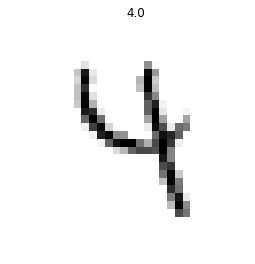

In [117]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

rand = random.randint(0, 69999)
some_digit = X[rand]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.title(y[rand])
plt.axis("off")
plt.show()